In [1]:
# Dependencies
import numpy as np
import pandas as pd
from enum import Enum
import random
import matplotlib.pyplot as plt

from collections import deque

In [2]:
# Enums
class Color(Enum):
    RED = 0
    BLUE = 1
    YELLOW = 2
    GREEN = 3
    BLACK = 4

class Label(Enum):
    DANGEROUS = 0
    SAFE = 1

COLOR_TO_RGB = {
    0 : (255, 0, 0),
    1 : (0, 0, 255),
    2 : (255, 255, 0),
    3 : (0, 255, 0),
    4 : (0, 0, 0)
}

In [3]:
# Image Generation
class Image: # USE THIS CLASS TO DISPLAY / CREATE IMAGE
    def __init__(self, data, label, third_wire):
        self.data = data
        self.label = label
        self.third_wire = third_wire

    def display(self):
        n = self.data.shape[0]
        image_data = [[0 for _ in range(n)] for _ in range(n)]
        for i in range(n):
            for j in range(n):
                curr_val = self.data[i][j]
                image_data[i][j] = COLOR_TO_RGB[curr_val]

        plt.imshow(image_data)
        plt.axis("off")
        plt.show()

class DataSet:
    def __init__(self):
        self.image_data = []
        self.labels = []
        self.third_wires = []

    def add_image(self, image, label, third_wire):
        """Add an image to the dataset using raw data"""
        self.image_data.append(image)
        self.labels.append(label.value)
        self.third_wires.append(third_wire) 

class ImageGenerator:
    """Generates N (M x M) images and writes to data"""
    def __init__(self, num_images, dimensions = 20, write_path = None, dataset = None, seed = None):
        self.dimensions = dimensions
        self.seed = seed
        random.seed(seed)
        for _ in range(num_images):
            data, label, third_wire = self.generate(write_path is not None)
            if dataset is not None:
                dataset.add_image(data, label, third_wire)

            # TODO: Write to data (may not be necessary, gen is really fast)
            if write_path is not None:
                pass

    def generate(self, write_ = False):
        """Generate a single image and label it appropriately"""
        n = self.dimensions
        image_data = np.full((n, n), Color.BLACK.value)
        colors = [Color.RED, Color.BLUE, Color.YELLOW, Color.GREEN]

        # Keep track of rows/cols that can be used
        valid_rows = list(range(n))
        valid_cols = list(range(n))

        # 1  = Color Row
        # -1 = Color Col
        pointer = random.choice([1, -1])
        label = Label.SAFE
        yellow_placed = False
        third_wire = None

        for i in range(4):
            # Select a unused color
            curr_color = random.choice(colors)
            colors.remove(curr_color)

            # Determine which should be cut (if dangerous)
            if i == 2:
                third_wire = curr_color
            
            # Handle marking an image as DANGEROUS if red is placed before yellow
            yellow_placed = yellow_placed or curr_color == Color.YELLOW
            if curr_color == Color.RED and not yellow_placed:
                label = Label.DANGEROUS

            if pointer == 1:
                rand_idx = random.choice(valid_rows)
                valid_rows.remove(rand_idx)
                self.color_row(rand_idx, curr_color, image_data)
            else:
                rand_idx = random.choice(valid_cols)
                valid_cols.remove(rand_idx)
                self.color_column(rand_idx, curr_color, image_data)
                
            pointer *= -1
        
        return image_data, label, third_wire
            

    def color_column(self, col, color, arr):
        """Color the given column of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[i][col] = color.value

    def color_row(self, row, color, arr):
        """Color the given row of the image with the provided color"""
        n = self.dimensions
        for i in range(n):
            arr[row][i] = color.value

In [102]:
# Helper Functions
def load_image(dataset_obj, index):
    """Load a specific index of the dataset"""
    image_data = dataset_obj.image_data[index]
    label = dataset_obj.labels[index]
    third_wire = dataset_obj.third_wires[index]
    img = Image(image_data, label, third_wire)
    return img

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def train_test_validation_split(X, y, train_size = .8, test_size = .1, validation_size = .1):
    if train_size + test_size + validation_size != 1:
        print("Error: train + test + validation don't add up to 1.")
        return
    
    print(X.shape)
    examples, features = X.shape
    # Randomize Indexes
    index_array = np.arange(examples)
    random.shuffle(index_array)

    # Split up data
    num_training = int(examples * train_size)
    num_testing = int(examples * test_size)
    train_indices = index_array[:num_training]
    test_indices = index_array[num_training:(num_training + num_testing)]
    validation_indices = index_array[(num_training + num_testing):]
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    X_validation = X[validation_indices]
    y_validation = y[validation_indices]

    return X_train, y_train, X_test, y_test, X_validation, y_validation
    

def one_hot_encode(image_data):
    """One-Hot encode matrix of examples"""
    if not isinstance(image_data, np.ndarray):
        image_data = np.array(image_data)

    num_colors = 4
    examples, rows, cols = image_data.shape
    encoded_shape = (examples, rows, cols, num_colors)
    encoded_image = np.zeros(encoded_shape)
    for i in range(examples):
        for j in range(rows):
            for k in range(cols):
                for l in range(num_colors):
                    if l == image_data[i, j, k]:
                        encoded_image[i, j, k, l] = 1
                    
    return encoded_image

def apply_convolution(image_data, step_size):
    """Apply convolution"""
    num_images, W, _, C = image_data.shape
    
    # Kernel Initialization
    kernel = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])
    K = 3

    output_size = ((W - K) // step_size) + 1
    output = np.zeros((num_images, output_size, output_size, C))

    # For every image
    for n in range(num_images):

        # For every element of the feature map
        for i in range(output_size):
            for j in range(output_size):
                region = image_data[n, i : i + K, j : j + K] # (3, 3, 4) - pixel subregion
                for c in range(C):
                    output[n, i, j, c] += np.sum(kernel * region[:, :, c])
                    
    return relu(output)

def apply_pooling(image_data, P, mode_ = "max"):
    if mode_ not in ["max", "mean"]:
        return -1

    num_images, W, _, C = image_data.shape
    output_size = ((W - P) // 1) + 1
    output = np.zeros((num_images, output_size, output_size, C))

    for n in range(num_images):
        for i in range(output_size):
            for j in range(output_size):
                region = image_data[n, i : i + P, j : j + P] # (3, 3, 4) - pixel subregion
                for c in range(C):
                    func_ = np.max if mode_ == "max" else np.mean
                    output[n, i, j, c] = func_(region[:, :, c])
    return output


def preprocess_data(image_data, label_data):
    """Preprocess and encode image and label data for model training"""
    image_data = one_hot_encode(image_data)
    label_data = np.array(label_data)
    flattened_data = image_data.reshape(image_data.shape[0], -1)
    flattened_data = np.c_[np.ones(len(flattened_data)), flattened_data] 
    return flattened_data, label_data

def preprocess_data_plus(image_data, label_data):
    image_data = one_hot_encode(image_data)
    label_data = np.array(label_data)
    convolved = apply_convolution(image_data, 1)
    #pooled = apply_pooling(convolved, 2, "mean")

    flattened_data = convolved.reshape(convolved.shape[0], -1)
    flattened_data = np.c_[np.ones(len(flattened_data)), flattened_data] 
    return flattened_data, label_data
    
def plot_data(title, x_label, y_label, data):
    """Data should be either a list or tuple, where the list is a list of tuples.
    
    Tuple format: Data to be plotted, name of data"""
    fig, ax = plt.subplots()
    
    if isinstance(data, list):
        for d in data:
            ax.plot(d[0], label = d[1])
    else:
        ax.plot(data[0], label = data[1])
    ax.set_title(title)
    ax.set_xlabel(x_label) 
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.show()
    

In [126]:
# Logistic Regression - Task 1
class LogisticRegression:
    def __init__(self, X_train, y_train, X_test, y_test, X_val, y_val, lr, epsilon, regularization):
        self.n = len(X_train)                                           # of training examples
        self.d = len(X_train[0])                                        # of features
        self.X_train = X_train #np.c_[np.ones(self.n), X_train]         # Training data
        self.X_test = X_test                                            # Testing data
        self.X_val = X_val                                              # Validation data
        self.y_train = y_train                                          # Training classification Labels
        self.y_test = y_test                                            # Testing classification Labels
        self.y_val = y_val                                              # Validation classification Labels
        self.weights = np.zeros(self.d)                                 # Current parameters / weights with d rows
        self.lr = lr                                                    # Learning rate   
        self.epsilon = epsilon                                          # Early stopping difference
        self.regularization, self.Lambda, self.decay = regularization   # Type of regularization, penalty, and decay of the penalty

    # Helper methods 
    # dataset = 0 - train; 1 - val; 2 - test
    def dataset_picker(self, dataset = 0):
        if dataset == 0:
            return self.X_train, self.y_train
        elif dataset == 1:
            return self.X_test, self.y_test
        else:
            return self.X_val, self.y_val

    # Helper methods 
    def predict(self, inds=None, dataset = 0):
        """Compute h_w(x_i) for the provided weight values"""
        X, y = self.dataset_picker(dataset)
        if inds is None:
            inds = np.arange(len(X))
        
        dot_product = np.dot(X[inds], self.weights)
        return sigmoid(dot_product)

    def loss(self, y, p):
        """Compute the current value of average loss based on predictions"""
        c = 1e-10
        loss = np.mean(-y * np.log(p + c) - (1 - y) * np.log(1 - p + c))
        if self.regularization == 2:
            loss += sum(self.Lambda * np.square(self.weights))
        return loss
    
    def accuracy(self, gold_labels, preds):
        pred_labels = self.get_pred_labels(preds)
        correct = [1 if pred == gold else 0 for pred, gold in zip(pred_labels, gold_labels)]
        count, total = sum(correct), len(correct)
        acc = round(count/total*100, 2)
        
        return acc, count, total
    
    def predict_loss_acc(self, inds=None, dataset=0):
        X, y = self.dataset_picker(dataset)
        preds = self.predict(inds, dataset)

        loss = self.loss(y, preds)
        acc, correct, total = self.accuracy(y, preds)
        
        return loss, acc

    
    # Gradient Descent
    def gd(self):
        """Run Gradient Descent to find `parameters` to minimize loss"""
        # Shuffle data before each epoch
        # random.shuffle(self.examples)
        # for i in range(len(self.examples)):
        #errors = self.loss(self.labels, self.predict())
        residuals = self.predict() - self.y_train
        gradient = np.dot(self.X_train.T, residuals)
        self.weights -= self.lr * gradient
            
    def sgd(self):
        """Run a single iteration of SGD"""
        # Shuffle data before each epoch
        indices_array = np.arange(len(self.X_train))
        random.shuffle(indices_array)
        
        for ind in indices_array:
            residual = self.predict(ind) - self.y_train[ind]
            gradient = residual * self.X_train[ind]
            if self.regularization == 2:
                gradient += 2 * self.Lambda * self.weights
            self.weights -= self.lr * gradient
            

    def train_deterministic(self, epochs):
        """Run GD until # of epochs is exceeded OR convergence"""
        prev = float('inf')
        for epoch in range(epochs):
            self.gd()
            train_loss = self.loss(self.y_train, self.predict())
            if epoch % 5 == 0:
                print(f"{epoch} - Loss: {train_loss}")
                
            if prev - train_loss < self.epsilon:
                print(f"Stopping early at epoch {epoch} - Loss: {train_loss}")
                break
            prev = train_loss
            
        print(f"{epoch} - Loss: {train_loss}")

    # Stochastic Gradient Descent
    def train_stochastic(self, epochs, display_steps = 1):
        """Run SGD until # of epochs is exceeded OR convergence"""
        prev_loss = deque([float('inf')])
        prev_acc = deque([float('inf')])
        
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        print("Epoch    ValLoss   TrainLoss   ValAcc   TrainAcc   ")  
        for epoch in range(epochs):
            self.sgd()

            loss_train, acc_train = self.predict_loss_acc(dataset=0)
            loss_val, acc_val = self.predict_loss_acc(dataset=2)
            
            self.train_losses.append(loss_train)
            self.val_losses.append(loss_val)
            self.train_accuracies.append(acc_train)
            self.val_accuracies.append(acc_val)
                        
            mean_loss = sum(prev_loss)/len(prev_loss)
            mean_acc = sum(prev_acc)/len(prev_acc)

            if epoch % display_steps == 0:
                print(f"{epoch}       {round(loss_val, 3)}       {round(loss_train, 3)}       {acc_val}       {acc_train}")
                #print(f"LOSS: {epoch} - train: {loss_train}; val: {loss_val}; mean: {mean_loss}")
                #print(f"ACC: {epoch} - train: {acc_train}; val: {acc_val}, mean: {mean_acc}")
            
            if abs(mean_loss - loss_val) < self.epsilon:
            #if abs(mean_acc - loss_val) < self.epsilon:
                print(f"Stopping early at epoch {epoch}")
                break
            prev_loss.append(float(loss_val))
            prev_acc.append(float(acc_val))
            if len(prev_loss) > 5:
                prev_loss.popleft()
            if len(prev_acc) > 5:
                prev_acc.popleft()

            self.Lambda *= self.decay
                
    # Model Evaluation
    def indicator(self, pred):
        """Returns label 1 if p(y == 1) > .5, 0 if p(y == 1) < .5, and breaks ties randomly"""
        if pred > .5:
            return 1
        elif pred < .5:
            return 0
        return np.random.choice([0, 1])
    
    def get_pred_labels(self, preds):
        """Converts prediction probabilities into labels"""
        for i in range(len(preds)):
            preds[i] = self.indicator(preds[i])
            
        return preds

    def test(self):
        """Compute the accuracy of the models predictions for test and training data"""
        probs_train = self.predict(dataset=0)
        acc_train, correct_train, total_train = self.accuracy(self.y_train, probs_train)
        print(f"TRAINING ACCURACY: {acc_train}%, {correct_train}/{total_train}")
        
        probs_test = self.predict(dataset=1)
        acc_test, correct_test, total_test = self.accuracy(self.y_test, probs_test)
        print(f"TESTING ACCURACY: {acc_test}%, {correct_test}/{total_test}")

        plot_data(f"Loss In Relation to Epochs ({self.n} train samples)", "Epochs", "Loss", [(self.train_losses, "Train"), (self.val_losses, "Validation")])
        plot_data(f"Accuracy In Relation to Epochs ({self.n} train samples)", "Epochs", "Accuracy", [(self.train_accuracies, "Train"), (self.val_accuracies, "Validation")])


In [146]:
# Generate and Preprocess Data
data = DataSet()
img_gen = ImageGenerator(5000, dataset = data, seed = 718067190)
image_data, label_data = preprocess_data(data.image_data, data.labels)

In [147]:
lr = .01
epsilon = .0001
Lambda, decay = .01, .06
# 2 ==> L2, 1 ==> L1
regularization = (2, Lambda, decay)
ttv_split = train_test_validation_split(image_data, label_data) # train, test, and validation

logistic = LogisticRegression(*ttv_split, lr, epsilon, regularization)
sgd = logistic.train_stochastic(20000)
predictions = logistic.get_pred_labels(logistic.predict())

(5000, 1601)
Epoch    ValLoss   TrainLoss   ValAcc   TrainAcc   
0       0.742       0.697       50.2       56.62
1       0.712       0.666       52.8       60.77
2       0.718       0.649       53.6       61.1
3       0.694       0.629       57.6       64.88
4       0.693       0.611       56.2       67.65
5       0.673       0.599       60.2       68.85
6       0.69       0.592       59.8       68.62
7       0.671       0.577       60.8       70.65
8       0.654       0.554       61.6       74.62
9       0.637       0.539       63.2       76.65
10       0.627       0.525       63.4       78.05
11       0.637       0.524       60.6       77.28
12       0.647       0.518       64.0       77.38
13       0.621       0.495       65.6       82.35
14       0.634       0.505       64.4       76.88
15       0.622       0.482       64.4       81.55
16       0.606       0.467       66.2       84.95
17       0.598       0.461       66.8       85.05
18       0.594       0.45       67.2       86.7

TRAINING ACCURACY: 91.47%, 3659/4000
TESTING ACCURACY: 77.6%, 388/500


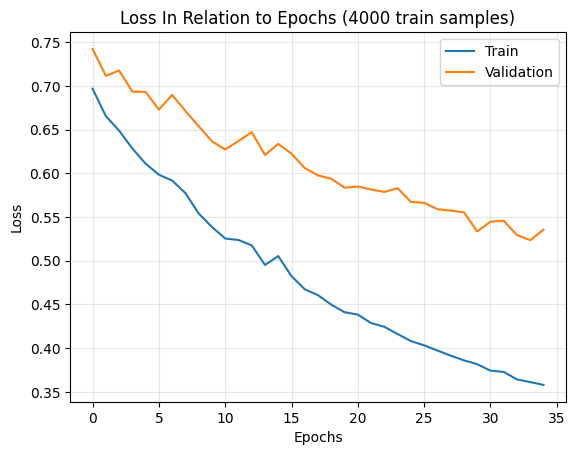

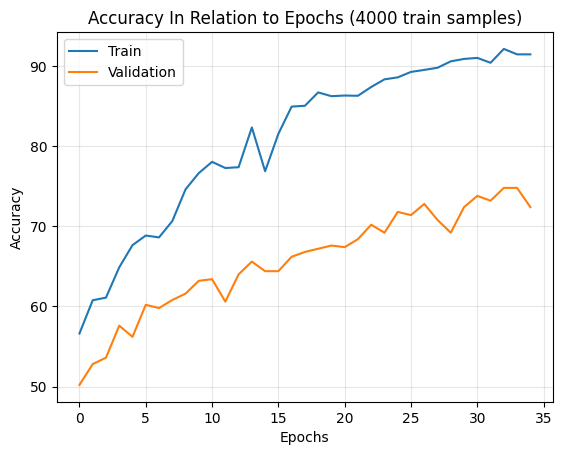

SUM OF WEIGHTS: 688.2779781523029


In [148]:
logistic.test()
print(f"SUM OF WEIGHTS: {sum(abs(logistic.weights))}")

In [ ]:
data.labels.count(0)

In [ ]:
for k in logistic.weights:
    print(k)

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

diagrams = logistic.X_train
labels = logistic.y_train

diagrams2 = logistic.X_test
labels2 = logistic.y_test

print(diagrams.shape, labels.shape)
print(diagrams2.shape, labels2.shape)

In [ ]:
model = LogisticRegression(max_iter=250)
model.fit(diagrams, labels)

predictions = model.predict(diagrams2)

accuracy = accuracy_score(labels2, predictions)
print("Test accuracy: ", accuracy)

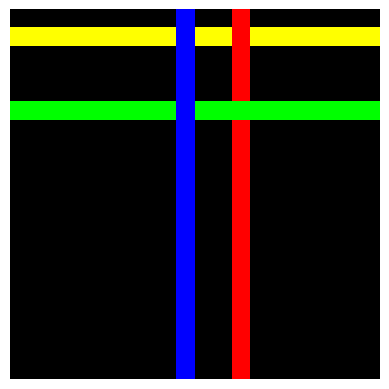

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.66666667, 1.        ,
        1.66666667, 1.        , 0.66666667, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55555556, 0.88888889,
        1.44444444, 0.88888889, 0.55555556, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55555556, 0.77777778,
        1.33333333, 0.77777778, 0.55555556, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.44444444, 0.66666667,
        1.11111111, 0.66666667, 0.44444444, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

In [101]:
# Convolution Testing
data = DataSet()
img_gen = ImageGenerator(5, dataset = data)
img_data = one_hot_encode(data.image_data)
load_image(data, 0).display()
convolved = apply_convolution(img_data, 1)
pooled = apply_pooling(convolved, 3, "mean")
pooled[0, :, :, 0]
# R B Y G
                                                 
                                                